# Spam Filtering

The aim of this kernel is to filter spam messages

**!! NOTE !!**  
*this kernel is only for documentation, i coded this from scratch in my Spyder IDE then move it here after it's done*

### Import Libraries

I will be utilizing nltk to help me for data cleaning which the process is including word tokenizing, lemmatizing, and removing stopwords. 
nltk is a library that specialized in natural language processing. It's easy to use, pretty complete, has many options, easy to use for beginner who learns about nlp.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import string
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from sklearn import svm, naive_bayes
from sklearn.feature_extraction.text import TfidfVectorizer

### Read Data

The data is in extension of .tsv which is a document separated by tab. I will create the Data Frame from it, it could be done by read_csv with adding parameter sep,names and header. The separator will be \t which means tab, the column names will be label and text, and the header is none because the document does not have any header

In [2]:
data = pd.read_csv(r"D:/python projects/read_files/SMSSpamCollection.tsv",
                    sep='\t',names=['label','text'], header=None)

### Exploraroty Data Analysis

Checking null, data shape, data type

In [3]:
data.head(5)

,label,text
0,ham,I've been searching for the right words to tha...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,"Nah I don't think he goes to usf, he lives aro..."
3,ham,Even my brother is not like to speak with me. ...
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!


In [4]:
data.isnull().sum()

label    0
text     0
dtype: int64

In [5]:
data.shape

(5568, 2)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5568 entries, 0 to 5567
Data columns (total 2 columns):
label    5568 non-null object
text     5568 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


In [7]:
data.describe()

,label,text
count,5568,5568
unique,2,5165
top,ham,"Sorry, I'll call later"
freq,4822,30


### Data Cleaning

I will set the stopwords in english language because from the text, the language used is english. Setting the variable will create a list of stopwords in english language and this will be use in removing stopwords.

In [8]:
stopwords = set(stopwords.words('english'))
wnl = WordNetLemmatizer()

I will make a function that does all of the process of data cleaning which is word tokenizing, lemmatizing and removing stopwords and punctuation. Firstly the data that has been lowercased will be tokenized into words, then each of the words in each list in each rows in the data will be check if they exist in stopwords or punctuation. If they don't exist in neither of stopwords or punctuation, the data will be lemmatize. Lemmatizing is a way of word normalization. Two types of word normalizations are word lemmatizing and word stemming.I choose lemmatize because it will extract the exact meaning of the word, e.g running, runs and run will be only run. Stemming is extracting meaning by cutting off the extensions which could confuse the actual meaning and sometimes return meaningless word. After normalizing the words, i will join the words again into sentence. Apply the function to the feature which is data['text'] and store it in new column.

In [9]:
def process(df):
    data = word_tokenize(df.lower())
    data = [wnl.lemmatize(word) for word in data if word not in (stopwords|set(string.punctuation))] #if nya harus return False, in order to return false harus tambahin | plus set() kalo gapake set gabisa
    data = " ".join([word for word in data])
    return data

In [10]:
data['clean_text'] = data['text'].apply(process)

In [11]:
data['clean_text'].head(10)

0    've searching right word thank breather promis...
1    free entry 2 wkly comp win fa cup final tkts 2...
2              nah n't think go usf life around though
3        even brother like speak treat like aid patent
4                                          date sunday
5    per request 'melle melle oru minnaminunginte n...
6    winner valued network customer selected receiv...
7    mobile 11 month u r entitled update latest col...
8    'm gon na home soon n't want talk stuff anymor...
9    six chance win cash 100 20,000 pound txt csh11...
Name: clean_text, dtype: object

#### Visualize Most Words Appeared with WordCloud

(-0.5, 399.5, 199.5, -0.5)

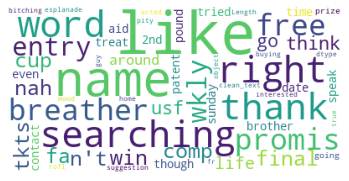

In [12]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=70, 
                          random_state=42
                         ).generate(str(data['clean_text']))

plt.imshow(wordcloud)
plt.axis('off')

#### Plotting Numbers of Ham vs Spam In Data

The plot below shows that spam texts appears significantly less than the non spam texts

Text(0.5, 1.0, 'Ham vs Spam')

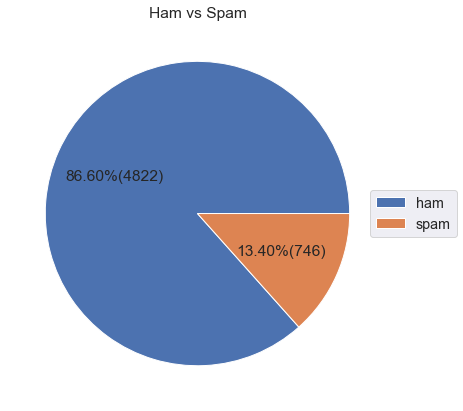

In [13]:
plt.figure(figsize=(7,7))
sns.set(font_scale=1.3)
plt.pie(data.groupby('label')['label'].count(),
        autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*data['label'].count()))
plt.legend(data['label'].unique(),loc='center right',
            bbox_to_anchor=(1, 0, 0.2, 1))
plt.title('Ham vs Spam')

### Data Splitting and Vectorizing

Firstly i will split the data into train and test data. I will vectorize the feature with ngram is 1,1 because above 1 in this case will result in worse performance. I will create variable X_test_remain to store the values of X_test before i vectorize the X_test, i do this so later i could see which text is spam/ham because vectorization will be manipulate the feature that it will not remain the same anymore.

In [14]:
X = np.array(data['clean_text'])
y = np.array(data['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

vectorizer = TfidfVectorizer(ngram_range=(1,1))

X_train = vectorizer.fit_transform(X_train)
X_test_remain = X_test.copy()
X_test = vectorizer.transform(X_test)

### Model Selection

I will create a function to compare each of the algorithm performance with cross validation. Since the algorithms are naive bayes and svm, they take different parameter, naive bayes could only be fed with dense array and svm could be fed with either dense or sparse array but feeding it dense array will take a very long time so i will feed it with sparse array. What i have for now is that the X_train is in form of sparse array (checked in Spyder IDE, this kernel is only for documentation, i coded this from scratch in my Spyder IDE then move it here after it's done) which means i need to put if conditional, for if the input type is dense then i will make it into array and if it's sparse then i will just feed the X_train. For that, i create a DataFrame which stores the algorithm, algorithm name and the input type

In [15]:
svm = svm.SVC()
nb = naive_bayes.GaussianNB()

alg = [nb,svm]
alg_name =['Naive Bayes','Support Vector Machine']
inputype = ['dense','sparse']

algorithms = pd.DataFrame(data=list(zip(alg,alg_name,inputype)),
                          columns=['algorithm','algorithm_name','input_type'])

scoring = {'accuracy' : make_scorer(accuracy_score), 
            'precision' : make_scorer(precision_score,pos_label='spam'),
            'recall' : make_scorer(recall_score,pos_label='spam'), 
            'f1_score' : make_scorer(f1_score,pos_label='spam')
            }

def model(X_train,y_train):
    for i,row in algorithms.iterrows():
        results = []
        if algorithms['input_type'][i] == 'dense':
            results = cross_validate(algorithms['algorithm'][i], X_train.toarray(),y_train,cv=10,scoring=scoring)
        elif algorithms['input_type'][i] == 'sparse':
            results = cross_validate(algorithms['algorithm'][i], X_train,y_train,cv=10,scoring=scoring)
        results = np.mean(list(results.values()),axis=1)
        print('{} evaluation scores'.format(algorithms['algorithm_name'][i]))
        print('fit time : {} \nscore time : {}\ntest accuracy : {}\ntest precision : {}\ntest recall : {}\ntest f1 score : {}\n'.format(*results))


From here we see that SVC outperforms GNB in most metrics so i will use SVM for my data

In [16]:
model(X_train, y_train)

Naive Bayes evaluation scores
fit time : 0.701722526550293 
score time : 0.10039186477661133
test accuracy : 0.8828079810550713
test precision : 0.5326587769821323
test recall : 0.8713617767387494
test f1 score : 0.6609799864528659

Support Vector Machine evaluation scores
fit time : 1.53431179523468 
score time : 0.12399287223815918
test accuracy : 0.9735083387917569
test precision : 0.9978260869565216
test recall : 0.7992986557568672
test f1 score : 0.8869247297594332



### Model Fitting

In [17]:
svm_model = svm.fit(X_train,y_train)
y_pred = svm_model.predict(X_test)

### Plotting Confusion Matrix

This shows how many hit and miss of our model for the data

Text(26.5, 0.5, 'True Label')

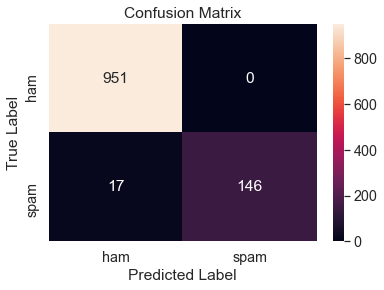

In [18]:
cm = confusion_matrix(y_test, y_pred)
class_label = ["ham", "spam"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
plt.figure()
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

In [19]:
final = pd.DataFrame(data=zip(X_test_remain,y_test,y_pred),columns=['Texts','Actual Label','Predicted Label'])

Let's see the big picture and save the result to csv

In [20]:
final

,Texts,Actual Label,Predicted Label
0,buy space invader 4 chance 2 win orig arcade g...,spam,spam
1,block breaker come deluxe format new feature g...,spam,ham
2,lol n't know awesome phone could click delete ...,ham,ham
3,hi 2nights ur lucky night uve invited 2 xchat ...,spam,spam
4,hamster dead hey tmr meet 1pm orchard mrt,ham,ham
...,...,...,...
1109,finally match heading towards draw prediction,ham,ham
1110,running managed 5 minute needed oxygen might r...,ham,ham
1111,wow healthy old airport rd lor cant thk anythi...,ham,ham
1112,call say coming today ok tell fool like ok,ham,ham


In [21]:
final.to_csv('submission.csv',index=False)

### Conclusion

Spam filtering could be categorized for NLP because the data used is a raw data and it takes special processes to create the model. It includes tokenization, normalization, vectorization which is pretty much different than regular preprocessing. SVM in this case outperforms the NB.